In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [33]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data preprocessing

#### Handle categorical variables & missing values

In [34]:
def process_data(df: pd.DataFrame, modes):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

In [35]:
modes = train_df.mode().iloc[0]
process_data(train_df, modes)
process_data(test_df, modes)

In [36]:
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep = 'Survived'

In [37]:
train_df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

#### Visualize male/female split (Survival rate & count)

[Text(0.5, 1.0, 'Histogram')]

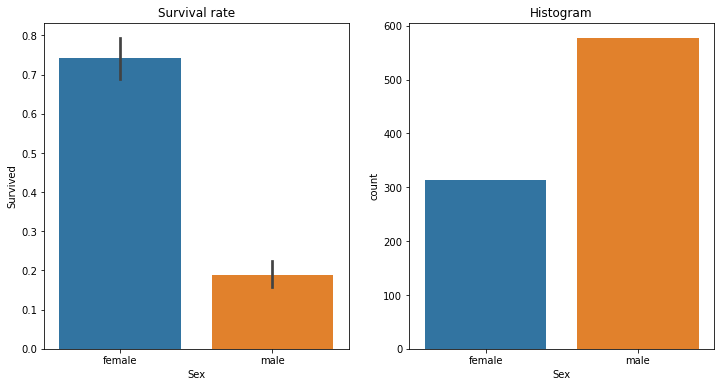

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.barplot(data=train_df, y=dep, x='Sex', ax=ax[0]).set(title='Survival rate')
sns.countplot(data=train_df, x='Sex', ax=ax[1]).set(title='Histogram')

#### Split train/validation data

In [39]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
train_df, val_df = train_test_split(train_df, test_size=0.25)
train_df[cats] = train_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [40]:
def xs_y(df: pd.DataFrame):
    xs = df[cats + conts].copy()
    return xs, df[dep] if dep in df else None

In [41]:
train_xs, train_y = xs_y(train_df)
val_xs, val_y = xs_y(val_df)

##### Dummy model #1 (considering Sex)

In [42]:
preds = val_xs.Sex == 0

In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

##### Dummy model #2 (considering LogFare)

<AxesSubplot:xlabel='LogFare', ylabel='Density'>

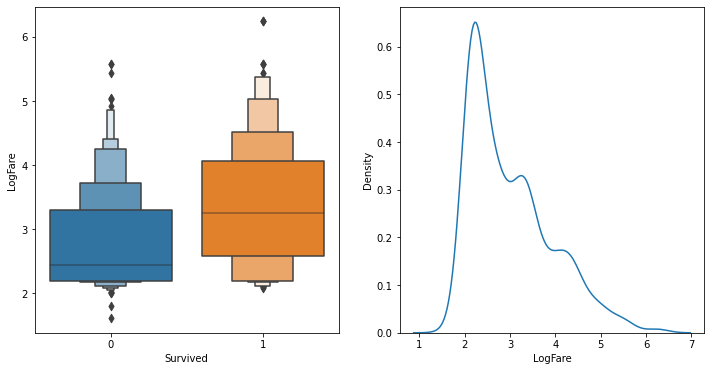

In [44]:
df_fare = train_df[train_df.LogFare > 0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.boxenplot(data=df_fare, x=dep, y='LogFare', ax=ax[0])
sns.kdeplot(data=df_fare, x='LogFare', ax=ax[1])

In [45]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(val_y, preds)

0.336322869955157

In [46]:
def _side_score(side, y):
    tot = side.sum()
    if tot <= 1:
        return 0
    return y[side].std() * tot

def score(col, y, split):
    lhs = col <= split
    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)

In [47]:
score(train_xs['Sex'], train_y, 0.5)

0.4078753098206398

In [48]:
score(train_xs['LogFare'], train_y, 2.7)

0.4718087395209973

In [49]:
nm = 'Age'
col = train_xs[nm]
unq = col.unique()
unq.sort()

In [50]:
scores = np.array([score(col, train_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [51]:
def min_col(df, nm):
    col, y = df[nm], df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx], scores[idx]

min_col(train_df, 'Age')

(6.0, 0.47831671750899085)

### Creating a Decision Tree

In [52]:
cols = cats + conts
{nm: min_col(train_df, nm) for nm in cols}

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

In [53]:
cols.remove('Sex')
is_male = train_df['Sex'] == 1
males, females = train_df[is_male], train_df[~is_male]

#### Example finding split for _males_

In [54]:
{o: min_col(males, o) for o in cols}

{'Embarked': (0, 0.387558187041091),
 'Age': (6.0, 0.37398283710105873),
 'SibSp': (4, 0.38758642275862637),
 'Parch': (0, 0.3874704821461953),
 'LogFare': (2.803360380906535, 0.38048562317581447),
 'Pclass': (1, 0.3815544200436083)}

#### Example finding split for _females_

In [55]:
{o: min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857326),
 'Age': (50.0, 0.4225927658431646),
 'SibSp': (4, 0.42319212059713585),
 'Parch': (3, 0.4193314500446157),
 'LogFare': (4.256321678298823, 0.413505983329114),
 'Pclass': (2, 0.3335388911567602)}

#### Using _sklearn_ to create a Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
model = DecisionTreeClassifier(max_leaf_nodes=4).fit(train_xs, train_y)

In [57]:
import graphviz
import re
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

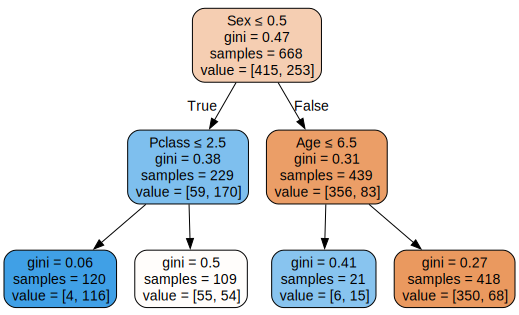

In [58]:
draw_tree(model, train_xs, size=10)

#### Computing _impurity_ using _Gini Index_
In this case it reflects the probability that, if you pick two rows from a group, you'll get the same Survived result each time. If the group is all the same, the probability is 1.0, and 0.0 if they're all different

In [68]:
def gini(df, condition):
    act = df.loc[condition, dep]
    return 1 - act.mean()**2 - (1 - act).mean()**2

In [70]:
gini_female = gini(train_df, train_df['Sex'] == 0) # Female
gini_male = gini(train_df, train_df['Sex'] == 1) # Male
(gini_female, gini_male)

(0.38252512347209255, 0.3066401689488951)